Binary 4/6 C)

mRNA localization using binary classification (endoplasmic reticulum/mitochondria) (part 3): basic model with: <br> 
<br>
a) Method 6: no feature selection and class weights accounted for <br>
b) Method 7: with feature importance-based feature selection (SHAP), w/ threshold > 0  and class weights accounted for<br>

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report


In [3]:
#data initialization


#Endoplasmic reticulum (label = 1)
ER_train = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_train_CSV.csv")
ER_test = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_test_CSV.csv")

#Mitochondria (label = 2)
MT_train = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_train_CSV.csv")
MT_test = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_test_CSV.csv")

print("ER TRAIN, TEST SHAPE:", ER_train.shape, ",", ER_test.shape)
print("MT TRAIN, TEST SHAPE:", MT_train.shape, ",", MT_test.shape)


ER TRAIN, TEST SHAPE: (296, 1026) , (74, 1026)
MT TRAIN, TEST SHAPE: (280, 1026) , (70, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:

#Group 4: ER + MT

frames_EM_tra = [ER_train, MT_train]
frames_EM_tes = [ER_test, MT_test]

ER_MT_train = pd.concat(frames_EM_tra)
ER_MT_test = pd.concat(frames_EM_tes)



In [6]:


print("\nER + MT TRAIN, TEST SHAPE:", ER_MT_train.shape, ",", ER_MT_test.shape)



ER + MT TRAIN, TEST SHAPE: (576, 1026) , (144, 1026)


In [7]:
ER_MT_test.head(77)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_9547#3911|1|testing,1,0.001311,0.000087,0.000262,0.000262,0.000000,0.000437,0.000175,0.000175,...,0.000087,0.000262,0.000175,0.000262,0.001224,0.000612,0.000175,0.000087,0.000175,0.000175
1,mRNALoc_11948#55102|1|testing,1,0.002614,0.000991,0.001893,0.003245,0.001532,0.000811,0.000541,0.001532,...,0.000180,0.002614,0.001442,0.001712,0.002073,0.001532,0.003335,0.002704,0.002524,0.003064
2,mRNALoc_18167#84629|1|testing,1,0.002457,0.000472,0.000567,0.000284,0.000189,0.000756,0.000095,0.000661,...,0.000378,0.000189,0.000284,0.000378,0.000472,0.000756,0.000567,0.000378,0.000378,0.001417
3,mRNALoc_4038#1952|1|testing,1,0.001044,0.000000,0.000854,0.000285,0.000095,0.000380,0.000190,0.000190,...,0.000285,0.000664,0.000759,0.001139,0.000759,0.000664,0.000475,0.000949,0.000569,0.001044
4,mRNALoc_19976#9881|1|testing,1,0.002954,0.001143,0.002192,0.001620,0.001239,0.001239,0.000572,0.000572,...,0.000191,0.001715,0.002668,0.000858,0.001429,0.000667,0.000667,0.001620,0.001810,0.002573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,mRNALoc_17982#84230|1|testing,1,0.004165,0.002777,0.002360,0.005137,0.002915,0.000972,0.000000,0.002221,...,0.000416,0.003193,0.002777,0.001666,0.001666,0.003054,0.004998,0.003193,0.003610,0.006247
73,mRNALoc_19858#9728|1|testing,1,0.009463,0.002922,0.003896,0.002922,0.002087,0.000974,0.000278,0.002922,...,0.000139,0.002644,0.002505,0.002505,0.001252,0.002087,0.003062,0.001392,0.003201,0.002783
0,mRNALoc_18808#856050|2|testing,2,0.001747,0.001747,0.005240,0.005240,0.001747,0.000873,0.002620,0.001747,...,0.000873,0.001747,0.001747,0.001747,0.001747,0.001747,0.001747,0.000873,0.001747,0.003493
1,mRNALoc_18516#852314|2|testing,2,0.010536,0.004390,0.004390,0.006146,0.003512,0.001756,0.000878,0.001756,...,0.000000,0.002634,0.003512,0.000878,0.003512,0.000878,0.001756,0.002634,0.004390,0.000000


In [8]:
#FOR ER+MT
noname_EM_train = ER_MT_train.drop("#", axis="columns")
noname_EM_test = ER_MT_test.drop("#", axis="columns")


ER_MT_X_train = noname_EM_train.drop("label", axis="columns")
ER_MT_y_train = noname_EM_train["label"]

ER_MT_X_test = noname_EM_test.drop("label", axis="columns")
ER_MT_y_test = noname_EM_test["label"]

print("ER + MT X train:", ER_MT_X_train.shape)
print("ER + MT y train:", ER_MT_y_train.shape)
print("ER + MT X test:", ER_MT_X_test.shape)
print("ER + MT y test:", ER_MT_y_test.shape)

ER + MT X train: (576, 1024)
ER + MT y train: (576,)
ER + MT X test: (144, 1024)
ER + MT y test: (144,)


In [9]:
# Create data pools for feature importance/selection for ER + MT

EM_feature_names = list(ER_MT_X_train.columns)
print("Number of features:", len(EM_feature_names))

EM_train_pool = Pool(ER_MT_X_train, ER_MT_y_train, feature_names=EM_feature_names)

EM_test_pool = Pool(ER_MT_X_test, ER_MT_y_test)

print("*ER, Mitochondria Pools created")

Number of features: 1024
*ER, Mitochondria Pools created


    Method 6: Basic model with class imbalance taken into account (but without feature importance/selection/hyperparameter tuning)

In [10]:
EM_binary_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

In [11]:
#Fit model to EM data

EM_binary_model.fit(EM_train_pool)

Learning rate set to 0.076932
0:	learn: 0.6502186	total: 222ms	remaining: 3m 41s
1:	learn: 0.6115869	total: 372ms	remaining: 3m 5s
2:	learn: 0.5793477	total: 509ms	remaining: 2m 49s
3:	learn: 0.5481953	total: 629ms	remaining: 2m 36s
4:	learn: 0.5207519	total: 748ms	remaining: 2m 28s
5:	learn: 0.4961479	total: 883ms	remaining: 2m 26s
6:	learn: 0.4712012	total: 1.02s	remaining: 2m 24s
7:	learn: 0.4482254	total: 1.15s	remaining: 2m 22s
8:	learn: 0.4257669	total: 1.27s	remaining: 2m 19s
9:	learn: 0.4028051	total: 1.4s	remaining: 2m 18s
10:	learn: 0.3847164	total: 1.53s	remaining: 2m 17s
11:	learn: 0.3679975	total: 1.66s	remaining: 2m 17s
12:	learn: 0.3518490	total: 1.89s	remaining: 2m 23s
13:	learn: 0.3379477	total: 2.04s	remaining: 2m 23s
14:	learn: 0.3242266	total: 2.19s	remaining: 2m 23s
15:	learn: 0.3117305	total: 2.31s	remaining: 2m 22s
16:	learn: 0.2993380	total: 2.44s	remaining: 2m 20s
17:	learn: 0.2870371	total: 2.56s	remaining: 2m 19s
18:	learn: 0.2784453	total: 2.68s	remaining: 2

In [12]:
#Check parameters used in this model fit

EM_bin_params = EM_binary_model.get_all_params()
print("Basic model parameters:", EM_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [1, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 1.0571428537368774], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Mult

In [13]:
#Prediction using X_test
EM_y_pred = EM_binary_model.predict(ER_MT_X_test)

#Predication probability

EM_y_prob = EM_binary_model.predict_proba(ER_MT_X_test)

In [14]:
# Calculate F1 score and get classification report

print("Model 6: Basic model w/ class imbalance accounted for - Endoplasmic reticulum & mitochondria")

EM_cr = classification_report(ER_MT_y_test, EM_y_pred, digits=4)
print(EM_cr)

print('Accuracy score: ', accuracy_score(ER_MT_y_test, EM_y_pred))

EM_f1 = f1_score(ER_MT_y_test, EM_y_pred, average='macro')
print(f"\nF1 Score: {EM_f1}")
# print('Roc auc score : ', roc_auc_score(ER_MT_y_test, EM_y_prob))

Model 6: Basic model w/ class imbalance accounted for - Endoplasmic reticulum & mitochondria
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        74
           2     1.0000    1.0000    1.0000        70

    accuracy                         1.0000       144
   macro avg     1.0000    1.0000    1.0000       144
weighted avg     1.0000    1.0000    1.0000       144

Accuracy score:  1.0

F1 Score: 1.0


In [15]:
# Confusion matrix for selected data

print("real values shape:", ER_MT_y_test.shape)
print("prediction shape:", EM_y_pred.shape)

EM_y_pred_fl = EM_y_pred
print("flattened prediction values shape:", EM_y_pred_fl.ravel().shape, "\n")

EM_cMatrix = confusion_matrix(ER_MT_y_test, EM_y_pred_fl)
print(EM_cMatrix)

real values shape: (144,)
prediction shape: (144, 1)
flattened prediction values shape: (144,) 

[[74  0]
 [ 0 70]]


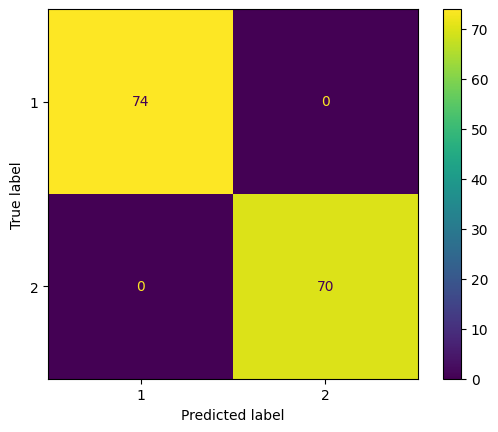

In [16]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=EM_cMatrix, display_labels=EM_binary_model.classes_)
disp.plot()
plt.show()

    Method 2: Feature importance-based feature selection

In [17]:
#Feature importances for EM pair

EM_feat_importances = EM_binary_model.get_feature_importance(prettified=True)
EM_feat_importances.head(100)

,Feature Id,Importances
0,ACGAA,5.706779
1,CAGCC,3.547273
2,TCGAA,3.463691
3,CCTGG,3.075387
4,CCCCC,2.842749
...,...,...
95,CTGCA,0.176979
96,AGGGT,0.176582
97,CCGCG,0.173902
98,GGAGC,0.173412


In [18]:
# Show only feature importances above 0.1

threshold_chosen_features = EM_feat_importances[EM_feat_importances['Importances'] >= 0.1]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0.1 (selected features):", num_chosen_features)

    Feature Id  Importances
0        ACGAA     5.706779
1        CAGCC     3.547273
2        TCGAA     3.463691
3        CCTGG     3.075387
4        CCCCC     2.842749
..         ...          ...
164      ACTAT     0.104537
165      GATGT     0.104293
166      AAGAA     0.102985
167      AGGAA     0.101604
168      AGTCC     0.100029

[169 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 169


In [19]:
print("Sum of total feature importances: ", sum(EM_feat_importances.Importances))
print("Sum of feature importances >=0.1: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  100.00000000000017
Sum of feature importances >=0.1:  86.75383692679328


In [20]:
# Select features with importance values above 0.1

EM_selected_feat = EM_feat_importances[:num_chosen_features]['Feature Id'].tolist()

print(EM_selected_feat)

['ACGAA', 'CAGCC', 'TCGAA', 'CCTGG', 'CCCCC', 'CGATT', 'CGTTA', 'TCGTT', 'ACGTT', 'TATCG', 'ACGAT', 'TCGAT', 'CAGCT', 'GCCTG', 'TCAGC', 'GACGA', 'CCTGC', 'CGTTG', 'CGATA', 'CCTCC', 'TGTAA', 'ATCAA', 'CGAAA', 'CCCAG', 'GGGGA', 'CCCTG', 'CGGTA', 'CAGTG', 'CCAGC', 'AACGC', 'TCCTG', 'CAGCA', 'AAAAA', 'ATAAA', 'GGGAG', 'ATGTG', 'ATCGT', 'CTCCT', 'AACGA', 'ATTGG', 'CTCTG', 'CGATG', 'CTGAG', 'TTTCG', 'ATGTA', 'CCAGG', 'TACGG', 'ATGGT', 'CTCAG', 'ATTAC', 'AGGGG', 'CCCTC', 'TTGGT', 'CTCCC', 'TACGA', 'TGACG', 'CAATT', 'ACCCC', 'TTTTT', 'GGTAA', 'GACGG', 'GGGGC', 'AGCAG', 'GTGTG', 'TGTGC', 'CACAG', 'CCGTT', 'CGCTA', 'CGAAT', 'GGGAA', 'TCGGA', 'GCAGC', 'ATTGA', 'GGCCC', 'AGACG', 'GGATC', 'ATCCG', 'AGTGA', 'ACGCT', 'CCGAT', 'TCGGT', 'CATTG', 'TTCGA', 'TTCGT', 'CTGCC', 'CTGGA', 'CTGGG', 'AGCCT', 'CGTAA', 'TCCCC', 'GCTTG', 'CCCGC', 'ACTAG', 'ATATT', 'CAGGG', 'CTGCA', 'AGGGT', 'CCGCG', 'GGAGC', 'ACCAG', 'TATTG', 'GGCTG', 'AAATG', 'GGAGA', 'CGAAG', 'ATGCG', 'TGCAG', 'TGTAT', 'ATTCA', 'ATCGA', 'GTCCC', 

In [21]:
ER_MT_X_train.shape

(576, 1024)

In [22]:
# See original training set

ER_MT_X_train.head(299)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443
1,0.007154,0.002602,0.001951,0.002927,0.002114,0.001789,0.000813,0.002114,0.002276,0.001463,...,0.000163,0.003252,0.001301,0.001789,0.000488,0.001789,0.002927,0.002439,0.002114,0.003415
2,0.002685,0.001007,0.002685,0.001510,0.001175,0.001678,0.000336,0.000671,0.002517,0.001007,...,0.000336,0.001175,0.000839,0.001678,0.001678,0.000503,0.000839,0.000671,0.001678,0.002182
3,0.010459,0.001609,0.000805,0.000000,0.000805,0.002414,0.001609,0.000000,0.000805,0.000000,...,0.000000,0.005632,0.000000,0.000805,0.000805,0.000805,0.000000,0.002414,0.000805,0.001609
4,0.000902,0.000451,0.002254,0.000902,0.000451,0.000000,0.000000,0.000451,0.002254,0.001353,...,0.000000,0.002254,0.001353,0.000902,0.002705,0.000902,0.002705,0.002254,0.002254,0.003607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.002263,0.001006,0.001090,0.001341,0.001760,0.000922,0.000168,0.001593,0.000922,0.000419,...,0.000168,0.001174,0.002012,0.001090,0.000922,0.001760,0.001006,0.001425,0.001257,0.001760
295,0.003929,0.001135,0.001572,0.000960,0.001135,0.000786,0.000175,0.000699,0.000873,0.001310,...,0.000175,0.001572,0.001746,0.000960,0.001222,0.001222,0.000611,0.000873,0.001484,0.001310
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435
1,0.006502,0.002956,0.001970,0.003941,0.004138,0.001576,0.001379,0.001379,0.002562,0.001970,...,0.000591,0.001970,0.001576,0.000394,0.001773,0.001773,0.004729,0.003350,0.002365,0.014778


In [23]:
#Create training set with selected features 

EM_X_train_selected = ER_MT_X_train[EM_selected_feat]
EM_X_train_selected.head()

,ACGAA,CAGCC,TCGAA,CCTGG,CCCCC,CGATT,CGTTA,TCGTT,ACGTT,TATCG,...,CATAG,TGCGT,AAAAT,GGAGG,AGGAG,ACTAT,GATGT,AAGAA,AGGAA,AGTCC
0,0.000000,0.001924,0.000240,0.002646,0.003127,0.000240,0.000240,0.000240,0.00024,0.000000,...,0.000481,0.000000,0.003608,0.001443,0.001684,0.000722,0.000240,0.003608,0.002405,0.000722
1,0.000163,0.002276,0.000163,0.001138,0.001789,0.000163,0.000000,0.000000,0.00000,0.000163,...,0.000813,0.000000,0.002927,0.001301,0.002764,0.001138,0.001301,0.004228,0.002276,0.000650
2,0.000000,0.002685,0.000000,0.003524,0.001007,0.000168,0.000336,0.000336,0.00000,0.000336,...,0.000168,0.000336,0.001510,0.004195,0.002517,0.000503,0.001510,0.002349,0.002182,0.000336
3,0.000000,0.006436,0.000000,0.000805,0.001609,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000805,0.001609,0.000000,0.000805,0.001609,0.000000,0.000000
4,0.000902,0.001353,0.000451,0.003607,0.001803,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000451,0.000451,0.000902,0.000451,0.002705,0.000902,0.000902,0.001803,0.000902,0.000451


In [24]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(EM_X_train_selected.columns) == EM_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [25]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", EM_X_train_selected.shape)
print("Shape of y_train (number of labels):", ER_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (576, 169)
Shape of y_train (number of labels): (576,)


In [26]:
# Create pool object for selected feature data
print("Original number of features:", len(EM_feature_names), "\n Number of selected features:", len(EM_selected_feat))

EM_selected_train_pool = Pool(EM_X_train_selected, ER_MT_y_train, feature_names=EM_selected_feat)

Original number of features: 1024 
 Number of selected features: 169


In [27]:
#Create new model for data with selected features
EM_FIFS_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

EM_FIFS_model.fit(EM_selected_train_pool)

Learning rate set to 0.076932
0:	learn: 0.6478218	total: 29.1ms	remaining: 29.1s
1:	learn: 0.6054725	total: 52.1ms	remaining: 26s
2:	learn: 0.5677403	total: 72.7ms	remaining: 24.2s
3:	learn: 0.5348651	total: 97ms	remaining: 24.1s
4:	learn: 0.5077123	total: 120ms	remaining: 23.8s
5:	learn: 0.4790486	total: 143ms	remaining: 23.7s
6:	learn: 0.4515479	total: 168ms	remaining: 23.8s
7:	learn: 0.4277848	total: 192ms	remaining: 23.8s
8:	learn: 0.4076340	total: 216ms	remaining: 23.8s
9:	learn: 0.3878775	total: 242ms	remaining: 23.9s
10:	learn: 0.3666286	total: 264ms	remaining: 23.8s
11:	learn: 0.3493179	total: 287ms	remaining: 23.6s
12:	learn: 0.3336485	total: 308ms	remaining: 23.4s
13:	learn: 0.3176434	total: 330ms	remaining: 23.3s
14:	learn: 0.3031303	total: 353ms	remaining: 23.2s
15:	learn: 0.2901023	total: 377ms	remaining: 23.2s
16:	learn: 0.2782295	total: 400ms	remaining: 23.2s
17:	learn: 0.2665959	total: 423ms	remaining: 23.1s
18:	learn: 0.2542291	total: 444ms	remaining: 22.9s
19:	learn: 

In [28]:
#Check parameters used in this model fit

EM_FIFS_params = EM_FIFS_model.get_all_params()
print("Basic model parameters:", EM_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [1, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07693199813365936,

In [29]:
#Prediction using X_test only for selected features data
EM_FIFS_y_pred = EM_FIFS_model.predict(ER_MT_X_test)

#Predication probability for selected features data

EM_FIFS_y_prob = EM_FIFS_model.predict_proba(ER_MT_X_test)

In [30]:
# Calculate F1 score and get classification report

EM_FIFS_f1 = f1_score(ER_MT_y_test, EM_FIFS_y_pred, average='macro')
print(f"F1 Score: {EM_FIFS_f1}")

EM_FIFS_cr = classification_report(ER_MT_y_test, EM_FIFS_y_pred, digits=4)
print(EM_FIFS_cr)

print('Accuracy score: ', accuracy_score(ER_MT_y_test, EM_FIFS_y_pred))
# print('Roc auc score : ', roc_auc_score(ER_MT_y_test, EM_FIFS_y_prob))

F1 Score: 1.0
              precision    recall  f1-score   support

           1      1.000     1.000     1.000        74
           2      1.000     1.000     1.000        70

    accuracy                          1.000       144
   macro avg      1.000     1.000     1.000       144
weighted avg      1.000     1.000     1.000       144

Accuracy score:  1.0


In [31]:
# Confusion matrix for selected data

print("real values shape:", ER_MT_y_test.shape)
print("prediction shape:", EM_FIFS_y_pred.shape)

EM_FIFS_y_pred_fl = EM_FIFS_y_pred
print("flattened prediction values shape:", EM_FIFS_y_pred_fl.ravel().shape, "\n")

EM_FIFS_cMatrix = confusion_matrix(ER_MT_y_test, EM_FIFS_y_pred_fl)
print(EM_FIFS_cMatrix)

real values shape: (144,)
prediction shape: (144, 1)
flattened prediction values shape: (144,) 

[[74  0]
 [ 0 70]]


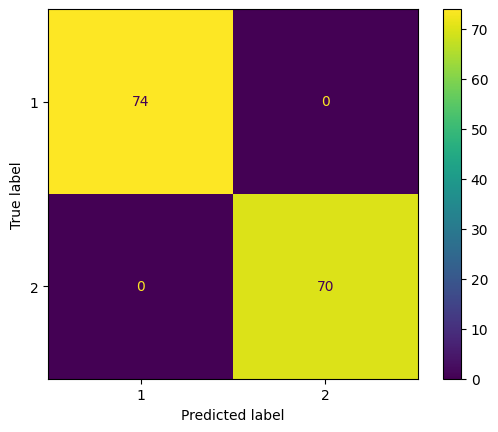

In [32]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=EM_FIFS_cMatrix, display_labels=EM_FIFS_model.classes_)
disp.plot()
plt.show()

    Method 7: Modelling using feature selection based on feature importance values (with get_feature_importances type = "ShapValues"), threshold > 0 with class weights accounted for

In [17]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(EM_binary_model)

In [18]:
#SHAP values for X_train
EM_shap_values = explainer.shap_values(ER_MT_X_train)

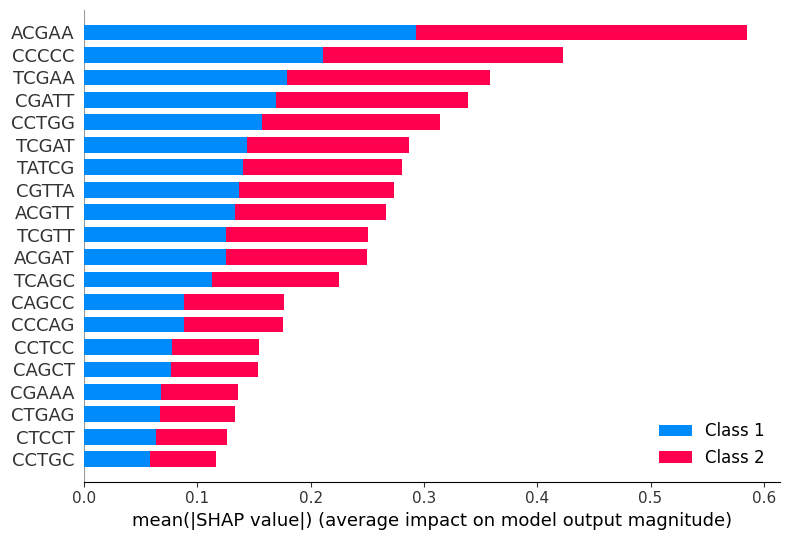

In [20]:
shap.summary_plot(EM_shap_values, ER_MT_X_train, plot_size=0.2, class_names=["Class 1", "Class 2"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


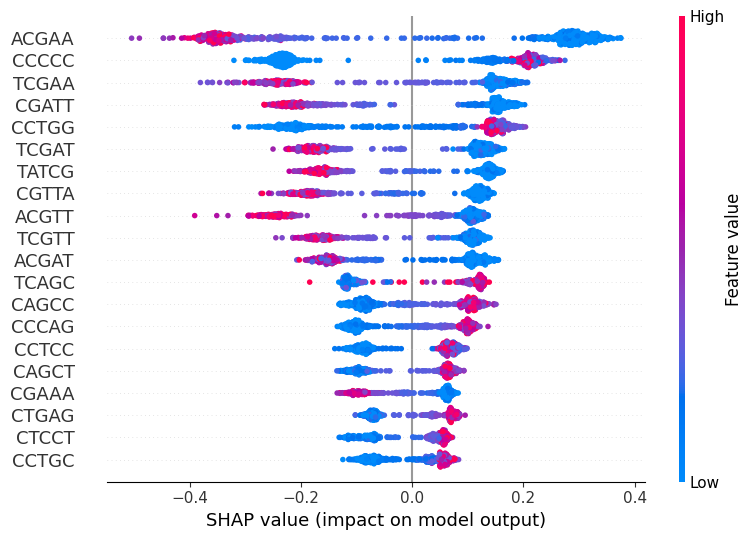

In [21]:
shap.summary_plot(EM_shap_values[0], ER_MT_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


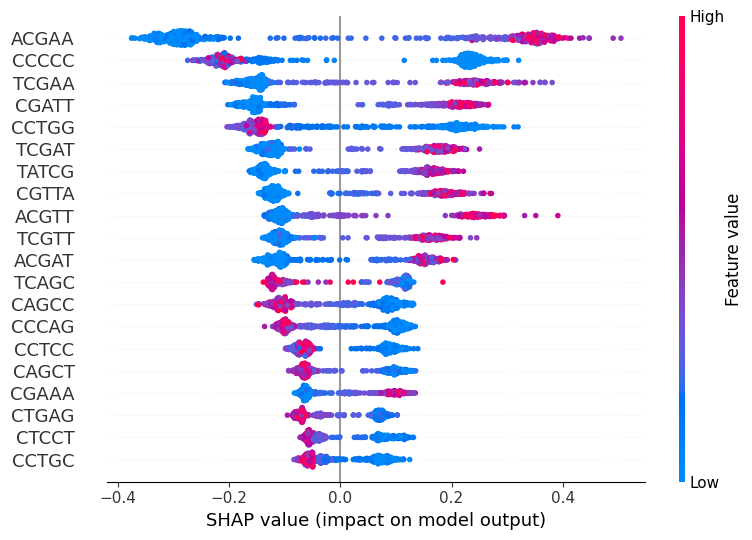

In [22]:
shap.summary_plot(EM_shap_values[1], ER_MT_X_train, plot_size=0.2)

In [23]:
shap_df = pd.DataFrame(EM_shap_values[0], columns=ER_MT_X_train.columns)


In [24]:
EM_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [25]:
EM_shap_FI.head(100)

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,ACGAA,0.276426
1,CCCCC,0.191211
2,CGATT,0.152884
3,TCGAA,0.145039
4,CCTGG,0.135099
...,...,...
95,CGGTT,0.012658
96,TGTGT,0.012622
97,GTTTA,0.012361
98,ATTGA,0.012302


In [27]:
# shap.summary_plot(EM_shap_values[0], ER_MT_X_train, show=False, max_display=30, plot_size=0.2)

In [28]:
# #Try####

# vals= np.abs(EM_shap_values).mean(0)

# newtry_feature_importance = pd.DataFrame(list(zip(ER_MT_X_train.columns, sum(vals))), columns=['col_name','feature_importanEM_vals'])
# newtry_feature_importance.sort_values(by=['feature_importanEM_vals'], ascending=False,inplace=True)
# newtry_feature_importance

In [29]:
# newtry_feature_importance.head(10)

In [30]:
#Classifier results with EM_feature_importance

In [32]:
# Show only feature importances above 0

EM_SHAP_thres_chosen = EM_shap_FI[EM_shap_FI['Importances'] > 0]
EM_shap_num_chosen = len(EM_SHAP_thres_chosen)

print(EM_SHAP_thres_chosen)

print("\nAmount of features with importnace above 0 (selected features):", EM_shap_num_chosen)

    Feature Id  Importances
0        ACGAA     0.276426
1        CCCCC     0.191211
2        CGATT     0.152884
3        TCGAA     0.145039
4        CCTGG     0.135099
..         ...          ...
713      CTATG     0.000018
714      CGTAT     0.000014
715      TGGAA     0.000013
716      AACAA     0.000009
717      AGCTC     0.000006

[718 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 718


In [33]:
print("Sum of total feature importances: ", sum(EM_shap_FI.Importances))
print("Sum of feature importances >=0.1: ", sum(EM_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances >=0.1:  6.170184644020482


In [35]:
# Select features with importance values above 0.1

EM_shap_selected_feat = EM_shap_FI[:EM_shap_num_chosen]['Feature Id'].tolist()

# print(EM_shap_selected_feat)

In [36]:
ER_MT_X_train.shape

(576, 1024)

In [37]:
# See original training set

ER_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443
1,0.007154,0.002602,0.001951,0.002927,0.002114,0.001789,0.000813,0.002114,0.002276,0.001463,...,0.000163,0.003252,0.001301,0.001789,0.000488,0.001789,0.002927,0.002439,0.002114,0.003415
2,0.002685,0.001007,0.002685,0.001510,0.001175,0.001678,0.000336,0.000671,0.002517,0.001007,...,0.000336,0.001175,0.000839,0.001678,0.001678,0.000503,0.000839,0.000671,0.001678,0.002182
3,0.010459,0.001609,0.000805,0.000000,0.000805,0.002414,0.001609,0.000000,0.000805,0.000000,...,0.000000,0.005632,0.000000,0.000805,0.000805,0.000805,0.000000,0.002414,0.000805,0.001609
4,0.000902,0.000451,0.002254,0.000902,0.000451,0.000000,0.000000,0.000451,0.002254,0.001353,...,0.000000,0.002254,0.001353,0.000902,0.002705,0.000902,0.002705,0.002254,0.002254,0.003607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,0.002593,0.000864,0.001729,0.003457,0.000864,0.000864,0.000000,0.000000,0.000864,0.000000,...,0.000000,0.001729,0.000864,0.000864,0.000864,0.000000,0.002593,0.000864,0.000000,0.000864
276,0.006066,0.002600,0.005199,0.005199,0.001733,0.000867,0.000000,0.005199,0.002600,0.002600,...,0.000867,0.002600,0.003466,0.001733,0.001733,0.000867,0.004333,0.002600,0.000867,0.000000
277,0.005213,0.002606,0.001738,0.001738,0.001738,0.000000,0.000000,0.001738,0.003475,0.000869,...,0.001738,0.003475,0.004344,0.003475,0.006082,0.002606,0.001738,0.002606,0.005213,0.003475
278,0.004355,0.000871,0.003484,0.005226,0.003484,0.000000,0.000000,0.000871,0.006098,0.003484,...,0.001742,0.004355,0.003484,0.002613,0.000000,0.002613,0.002613,0.006098,0.003484,0.007840


In [38]:
#Create training set with selected features 

EM_X_train_shap_selected = ER_MT_X_train[EM_shap_selected_feat]
EM_X_train_shap_selected.head()

,ACGAA,CCCCC,CGATT,TCGAA,CCTGG,TATCG,TCGAT,CGTTA,TCAGC,ATAAA,...,GCTGA,GCTCC,GACAT,GATCC,GTGAT,CTATG,CGTAT,TGGAA,AACAA,AGCTC
0,0.000000,0.003127,0.000240,0.000240,0.002646,0.000000,0.000240,0.000240,0.001924,0.003367,...,0.002165,0.000962,0.001203,0.000240,0.000722,0.000240,0.000000,0.001443,0.001203,0.001443
1,0.000163,0.001789,0.000163,0.000163,0.001138,0.000163,0.000000,0.000000,0.001301,0.001951,...,0.001138,0.001138,0.000976,0.000813,0.001626,0.000650,0.000488,0.001463,0.000976,0.000813
2,0.000000,0.001007,0.000168,0.000000,0.003524,0.000336,0.000168,0.000336,0.000336,0.000671,...,0.000839,0.001846,0.000503,0.000000,0.001007,0.000671,0.000168,0.001678,0.000839,0.001846
3,0.000000,0.001609,0.000000,0.000000,0.000805,0.000000,0.000805,0.000000,0.000805,0.002414,...,0.001609,0.002414,0.001609,0.001609,0.000805,0.002414,0.000000,0.001609,0.000805,0.002414
4,0.000902,0.001803,0.000000,0.000451,0.003607,0.000000,0.000000,0.000000,0.000451,0.000451,...,0.001353,0.000000,0.000451,0.000451,0.001353,0.002254,0.000451,0.003156,0.000451,0.000451


In [39]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(EM_X_train_shap_selected.columns) == EM_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [40]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", EM_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", ER_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (576, 718)
Shape of y_train (number of labels): (576,)


In [41]:
# Create pool object for selected feature data
print("Original number of features:", len(EM_feature_names), "\n Number of selected features:", len(EM_shap_selected_feat))

EM_shap_selected_train_pool = Pool(EM_X_train_shap_selected, ER_MT_y_train, feature_names=EM_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 718


In [42]:
#Create new model for data with selected features
EM_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

EM_FIFS_shap_model.fit(EM_shap_selected_train_pool)

Learning rate set to 0.076932
0:	learn: 0.6524626	total: 172ms	remaining: 2m 51s
1:	learn: 0.6164348	total: 267ms	remaining: 2m 13s
2:	learn: 0.5805082	total: 361ms	remaining: 2m
3:	learn: 0.5498136	total: 473ms	remaining: 1m 57s
4:	learn: 0.5175807	total: 656ms	remaining: 2m 10s
5:	learn: 0.4906167	total: 770ms	remaining: 2m 7s
6:	learn: 0.4650659	total: 895ms	remaining: 2m 6s
7:	learn: 0.4403909	total: 1.01s	remaining: 2m 4s
8:	learn: 0.4176566	total: 1.11s	remaining: 2m 2s
9:	learn: 0.3964463	total: 1.2s	remaining: 1m 59s
10:	learn: 0.3745612	total: 1.31s	remaining: 1m 57s
11:	learn: 0.3554697	total: 1.4s	remaining: 1m 55s
12:	learn: 0.3392610	total: 1.5s	remaining: 1m 53s
13:	learn: 0.3246437	total: 1.59s	remaining: 1m 52s
14:	learn: 0.3106851	total: 1.68s	remaining: 1m 50s
15:	learn: 0.2981565	total: 1.76s	remaining: 1m 48s
16:	learn: 0.2866352	total: 1.85s	remaining: 1m 46s
17:	learn: 0.2742094	total: 1.93s	remaining: 1m 45s
18:	learn: 0.2646376	total: 2.02s	remaining: 1m 44s
19:

In [43]:
#Check parameters used in this model fit

EM_FIFS_shap_params = EM_FIFS_shap_model.get_all_params()
print("Basic model parameters:", EM_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [1, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 1.0571428537368774], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Mult

In [44]:
#Prediction using X_test only for selected features data
EM_FIFS_shap_y_pred = EM_FIFS_shap_model.predict(ER_MT_X_test)

#Predication probability for selected features data

EM_FIFS_shap_y_prob = EM_FIFS_shap_model.predict_proba(ER_MT_X_test)

In [47]:
# Calculate F1 score and get classification report

print("Model 7: Feature selection (SHAP) w/ threshold > 0 and class imbalance accounted for - \nEndoplasmic reticulum & mitochondria")

print("\nNumber of chosen features:", len(EM_shap_selected_feat), "\n")

EM_FIFS_shap_cr = classification_report(ER_MT_y_test, EM_FIFS_shap_y_pred, digits=4)
print(EM_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(ER_MT_y_test, EM_FIFS_shap_y_pred))

EM_FIFS_shap_f1 = f1_score(ER_MT_y_test, EM_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {EM_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(ER_MT_y_test, EM_FIFS_shap_y_prob))

Model 7: Feature selection (SHAP) w/ threshold > 0 and class imbalance accounted for - 
Endoplasmic reticulum & mitochondria

Number of chosen features: 718 

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        74
           2     1.0000    1.0000    1.0000        70

    accuracy                         1.0000       144
   macro avg     1.0000    1.0000    1.0000       144
weighted avg     1.0000    1.0000    1.0000       144

Accuracy score:  1.0

F1 Score: 1.0


In [48]:
# Confusion matrix for selected data

print("real values shape:", ER_MT_y_test.shape)
print("prediction shape:", EM_FIFS_shap_y_pred.shape)

EM_FIFS_shap_y_pred_fl = EM_FIFS_shap_y_pred
print("flattened prediction values shape:", EM_FIFS_shap_y_pred_fl.ravel().shape, "\n")

EM_FIFS_shap_cMatrix = confusion_matrix(ER_MT_y_test, EM_FIFS_shap_y_pred_fl)
print(EM_FIFS_shap_cMatrix)

real values shape: (144,)
prediction shape: (144, 1)
flattened prediction values shape: (144,) 

[[74  0]
 [ 0 70]]


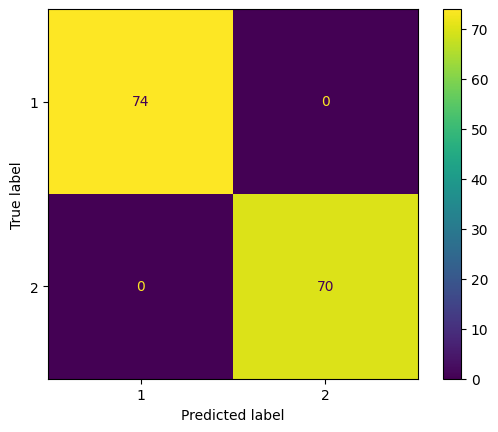

In [49]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=EM_FIFS_shap_cMatrix, display_labels=EM_FIFS_shap_model.classes_)
disp.plot()
plt.show()

In [60]:
#Classifier results with newtry_feature_importance

In [61]:
newtry_feature_importance.head(100)

,col_name,feature_importanEM_vals
96,ACGAA,163.218798
341,CCCCC,124.796957
864,TCGAA,108.120087
399,CGATT,92.097727
111,ACGTT,84.285502
...,...,...
182,AGTCG,7.557760
1023,TTTTT,7.526182
198,ATACG,7.435719
107,ACGGT,7.249166


In [62]:
# Show only feature importances above 0.1

EM_newSHAP_thres_chosen = newtry_feature_importance[:100]
EM_newshap_num_chosen = len(EM_newSHAP_thres_chosen)

print(EM_newSHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", EM_newshap_num_chosen)

     col_name  feature_importanEM_vals
96      ACGAA               163.218798
341     CCCCC               124.796957
864     TCGAA               108.120087
399     CGATT                92.097727
111     ACGTT                84.285502
...       ...                      ...
182     AGTCG                 7.557760
1023    TTTTT                 7.526182
198     ATACG                 7.435719
107     ACGGT                 7.249166
764     GTTTA                 7.229393

[100 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 100


In [63]:
print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importanEM_vals))
print("Sum of feature importances >=0.1: ", sum(EM_newSHAP_thres_chosen.feature_importanEM_vals))

Sum of total feature importances:  3634.9912638015876
Sum of feature importances >=0.1:  2640.9205708909826


In [64]:
# Select features with importance values above 0.1

EM_newshap_selected_feat = newtry_feature_importance[:EM_newshap_num_chosen]['col_name'].tolist()

print(EM_newshap_selected_feat)

['ACGAA', 'CCCCC', 'TCGAA', 'CGATT', 'ACGTT', 'TCGTT', 'CCTGG', 'TCGAT', 'CGTTA', 'TATCG', 'CAGCC', 'TCAGC', 'ACGAT', 'CAGCT', 'CCCAG', 'CCTCC', 'CGAAA', 'ATCAA', 'GCCTG', 'CCTGC', 'CGTTG', 'CAGTG', 'CGATA', 'TGTAA', 'AACGC', 'GACGA', 'AAAAA', 'CAGCA', 'CGGTA', 'CCCTG', 'CCAGC', 'GGGAG', 'CTGAG', 'ATAAA', 'TCCTG', 'CCAGG', 'AACGA', 'CTCCT', 'GGTAA', 'CTCAG', 'CAATT', 'TACGG', 'ATTGG', 'ATCGT', 'AGGGG', 'TTTCG', 'ACCCC', 'TGTGC', 'CTCTG', 'ATGGT', 'GGGGA', 'CGATG', 'CTCCC', 'CACAG', 'GGCCC', 'TTGGT', 'CGAAT', 'TACGA', 'AGACG', 'AGCAG', 'CCCTC', 'TCCCC', 'GGGGC', 'ATGTA', 'GTGTG', 'CAGGG', 'ATGTG', 'ACTAG', 'GGCTG', 'ATTAC', 'TTACG', 'GTCGT', 'CATTG', 'GGAGC', 'GCAGC', 'AGTGA', 'CTGGG', 'ATGCG', 'TTCGA', 'ATCTG', 'CTGGA', 'GGGAA', 'ACCAG', 'CCCGC', 'TTCGT', 'CGTAA', 'TGCAG', 'CCCCT', 'CTGCA', 'ATTCA', 'GGAGG', 'GCCCT', 'CCGAT', 'CCAAT', 'GTCCC', 'AGTCG', 'TTTTT', 'ATACG', 'ACGGT', 'GTTTA']


In [65]:
ER_MT_X_train.shape

(576, 1024)

In [66]:
# See original training set

ER_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443
1,0.007154,0.002602,0.001951,0.002927,0.002114,0.001789,0.000813,0.002114,0.002276,0.001463,...,0.000163,0.003252,0.001301,0.001789,0.000488,0.001789,0.002927,0.002439,0.002114,0.003415
2,0.002685,0.001007,0.002685,0.001510,0.001175,0.001678,0.000336,0.000671,0.002517,0.001007,...,0.000336,0.001175,0.000839,0.001678,0.001678,0.000503,0.000839,0.000671,0.001678,0.002182
3,0.010459,0.001609,0.000805,0.000000,0.000805,0.002414,0.001609,0.000000,0.000805,0.000000,...,0.000000,0.005632,0.000000,0.000805,0.000805,0.000805,0.000000,0.002414,0.000805,0.001609
4,0.000902,0.000451,0.002254,0.000902,0.000451,0.000000,0.000000,0.000451,0.002254,0.001353,...,0.000000,0.002254,0.001353,0.000902,0.002705,0.000902,0.002705,0.002254,0.002254,0.003607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,0.002593,0.000864,0.001729,0.003457,0.000864,0.000864,0.000000,0.000000,0.000864,0.000000,...,0.000000,0.001729,0.000864,0.000864,0.000864,0.000000,0.002593,0.000864,0.000000,0.000864
276,0.006066,0.002600,0.005199,0.005199,0.001733,0.000867,0.000000,0.005199,0.002600,0.002600,...,0.000867,0.002600,0.003466,0.001733,0.001733,0.000867,0.004333,0.002600,0.000867,0.000000
277,0.005213,0.002606,0.001738,0.001738,0.001738,0.000000,0.000000,0.001738,0.003475,0.000869,...,0.001738,0.003475,0.004344,0.003475,0.006082,0.002606,0.001738,0.002606,0.005213,0.003475
278,0.004355,0.000871,0.003484,0.005226,0.003484,0.000000,0.000000,0.000871,0.006098,0.003484,...,0.001742,0.004355,0.003484,0.002613,0.000000,0.002613,0.002613,0.006098,0.003484,0.007840


In [67]:
#Create training set with selected features 

EM_X_train_newshap_selected = ER_MT_X_train[EM_newshap_selected_feat]
EM_X_train_newshap_selected.head()

,ACGAA,CCCCC,TCGAA,CGATT,ACGTT,TCGTT,CCTGG,TCGAT,CGTTA,TATCG,...,GGAGG,GCCCT,CCGAT,CCAAT,GTCCC,AGTCG,TTTTT,ATACG,ACGGT,GTTTA
0,0.000000,0.003127,0.000240,0.000240,0.00024,0.000240,0.002646,0.000240,0.000240,0.000000,...,0.001443,0.001203,0.000000,0.001203,0.000962,0.000000,0.001443,0.000240,0.000000,0.000722
1,0.000163,0.001789,0.000163,0.000163,0.00000,0.000000,0.001138,0.000000,0.000000,0.000163,...,0.001301,0.000488,0.000813,0.000976,0.000325,0.000000,0.003415,0.000325,0.000325,0.000488
2,0.000000,0.001007,0.000000,0.000168,0.00000,0.000336,0.003524,0.000168,0.000336,0.000336,...,0.004195,0.002182,0.000168,0.000336,0.001510,0.000671,0.002182,0.000168,0.000168,0.000336
3,0.000000,0.001609,0.000000,0.000000,0.00000,0.000000,0.000805,0.000805,0.000000,0.000000,...,0.000805,0.000805,0.000805,0.001609,0.000000,0.000000,0.001609,0.000000,0.000000,0.000805
4,0.000902,0.001803,0.000451,0.000000,0.00000,0.000000,0.003607,0.000000,0.000000,0.000000,...,0.000451,0.001353,0.000000,0.000902,0.000902,0.000451,0.003607,0.000451,0.000902,0.000451


In [68]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(EM_X_train_newshap_selected.columns) == EM_newshap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [69]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", EM_X_train_newshap_selected.shape)
print("Shape of y_train (number of labels):", ER_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (576, 100)
Shape of y_train (number of labels): (576,)


In [70]:
# Create pool object for selected feature data
print("Original number of features:", len(EM_feature_names), "\n Number of selected features:", len(EM_newshap_selected_feat))

EM_newshap_selected_train_pool = Pool(EM_X_train_newshap_selected, ER_MT_y_train, feature_names=EM_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 100


In [71]:
#Create new model for data with selected features
EM_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

EM_FIFS_newshap_model.fit(EM_newshap_selected_train_pool)

Learning rate set to 0.076932
0:	learn: 0.6451446	total: 20.8ms	remaining: 20.8s
1:	learn: 0.6029992	total: 35ms	remaining: 17.5s
2:	learn: 0.5636243	total: 47.1ms	remaining: 15.7s
3:	learn: 0.5282339	total: 61.4ms	remaining: 15.3s
4:	learn: 0.4985467	total: 76.2ms	remaining: 15.2s
5:	learn: 0.4698538	total: 89.4ms	remaining: 14.8s
6:	learn: 0.4423817	total: 103ms	remaining: 14.7s
7:	learn: 0.4191345	total: 118ms	remaining: 14.6s
8:	learn: 0.3977296	total: 131ms	remaining: 14.5s
9:	learn: 0.3757734	total: 145ms	remaining: 14.3s
10:	learn: 0.3566002	total: 240ms	remaining: 21.6s
11:	learn: 0.3394880	total: 260ms	remaining: 21.4s
12:	learn: 0.3229074	total: 272ms	remaining: 20.7s
13:	learn: 0.3093423	total: 308ms	remaining: 21.7s
14:	learn: 0.2942837	total: 321ms	remaining: 21s
15:	learn: 0.2826522	total: 334ms	remaining: 20.6s
16:	learn: 0.2707877	total: 347ms	remaining: 20.1s
17:	learn: 0.2587607	total: 359ms	remaining: 19.6s
18:	learn: 0.2482395	total: 371ms	remaining: 19.1s
19:	learn

In [72]:
#Check parameters used in this model fit

EM_FIFS_newshap_params = EM_FIFS_newshap_model.get_all_params()
print("Basic model parameters:", EM_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [1, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07693199813365936,

In [73]:
#Prediction using X_test only for selected features data
EM_FIFS_newshap_y_pred = EM_FIFS_newshap_model.predict(ER_MT_X_test)

#Predication probability for selected features data

EM_FIFS_newshap_y_prob = EM_FIFS_newshap_model.predict_proba(ER_MT_X_test)

In [74]:
# Calculate F1 score and get classification report

EM_FIFS_newshap_f1 = f1_score(ER_MT_y_test, EM_FIFS_newshap_y_pred, average='macro')
print(f"F1 Score: {EM_FIFS_newshap_f1}")

EM_FIFS_newshap_cr = classification_report(ER_MT_y_test, EM_FIFS_newshap_y_pred, digits=4)
print(EM_FIFS_newshap_cr)

print('Accuracy score: ', accuracy_score(ER_MT_y_test, EM_FIFS_newshap_y_pred))
# print('Roc auc score : ', roc_auc_score(ER_MT_y_test, EM_FIFS_newshap_y_prob))

F1 Score: 1.0
              precision    recall  f1-score   support

           1      1.000     1.000     1.000        74
           2      1.000     1.000     1.000        70

    accuracy                          1.000       144
   macro avg      1.000     1.000     1.000       144
weighted avg      1.000     1.000     1.000       144

Accuracy score:  1.0


In [75]:
# Confusion matrix for selected data

print("real values shape:", ER_MT_y_test.shape)
print("prediction shape:", EM_FIFS_newshap_y_pred.shape)

EM_FIFS_newshap_y_pred_fl = EM_FIFS_newshap_y_pred
print("flattened prediction values shape:", EM_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

EM_FIFS_newshap_cMatrix = confusion_matrix(ER_MT_y_test, EM_FIFS_newshap_y_pred_fl)
print(EM_FIFS_newshap_cMatrix)

real values shape: (144,)
prediction shape: (144, 1)
flattened prediction values shape: (144,) 

[[74  0]
 [ 0 70]]


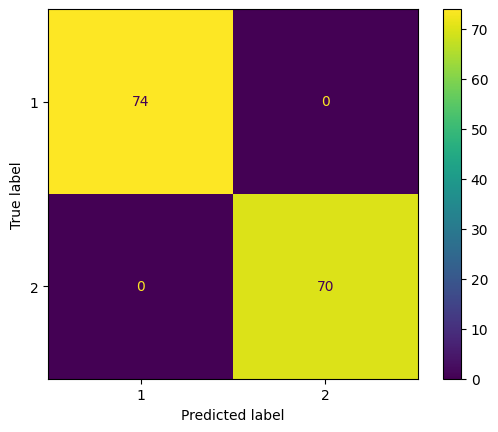

In [76]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=EM_FIFS_newshap_cMatrix, display_labels=EM_FIFS_newshap_model.classes_)
disp.plot()
plt.show()